This notebook introduces the use of dictionaries for counting the frequency of some category of words in text, using sentiment (from the [AFINN sentiment lexicon](http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010)) in the time series data of tweets as an example.

This notebook uses data from the AFINN sentiment lexicon; for other dictionaries in wide use, see [MPQA](https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/) (free for use with registration) and [LIWC](http://liwc.wpengine.com) (commercial).

Before running this notebook, install pandas:

```sh
source activate anlp
conda install pandas=0.24.0
conda install matplotlib=3.0.2
```

In [1]:
import json
import nltk
import pandas as pd
import matplotlib
import re

In [2]:
# read in json file of tweets and return a list of (date, tokenized text)
def read_tweets_from_json(filename):
    
    tweets=[]
    with open(filename, encoding="utf-8") as file:
        data=json.load(file)
        for tweet in data:
            created_at=tweet["created_at"]
            date = pd.to_datetime(created_at)
            text=tweet["text"]
            tokens=nltk.casual_tokenize(text)
            tweets.append((date, tokens))
    return tweets

In [3]:
# read in list of (date, tokens) tweets and count whether each tweet contains 
# a (lowercased) term in the argument dictionary.  Return as pandas dataframe
# for easier slicing/plotting)
def dictionary_document_count(data, dictionary):
    counted=[]
    for date, tokens in data:
        val=0
        for word in tokens:
            if word.lower() in dictionary:
                val=1
        counted.append((date, val))
    df=pd.DataFrame(counted, columns=['date','document frequency'])
    return df

In [4]:
tweets=read_tweets_from_json("../data/trump_tweets.json")

In [30]:
aoc_tweets =read_tweets_from_json("../data/aoc_tweets.json")

Here we'll define our own "immigration" dictionary by selecting words that we hypothesize are often found in the topic of immigration.

In [5]:
immigration_dictionary=set(["wall", "border", "borders", "immigrants","immigration"])

In [6]:
counts=dictionary_document_count(tweets, immigration_dictionary)

In [8]:
def plot_time(counts):
    
    # for this exercise, let's just keep tweets published after 2015
    counts=counts[(counts['date'] > '2015-01-01')]
    
    # counts is a pandas dataframe; let's aggregate the counts by month.  
    # Can also aggregate by "D" for day, "W" for week, "Y" for year.
    means=counts.resample('M', on='date').mean() 
    
    means.plot()

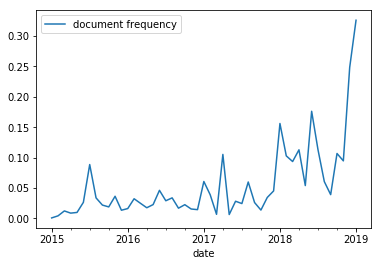

In [10]:
# You might need to run this command twice if you get a warning
plot_time(counts)

Q1: The AFINN dictionary is a sentiment lexicon, where words are rated on a five-point affect scale (-5 = most negative, 5 = most positive).  Write a function `read_AFINN_dictionary` to read in this file and create two dictionaries like that above -- one for positive terms and one for negative terms.  How did you decide the cutoff point for positive and negative?

#### Answer: Since AFFINN is an established sentiment dictionaries labeled by researchers in the area, I decide to trust that the positive and negative scores follow certain defined standards. I validated it by reading through words that are at the boundary (with score 0, -1, 1) and I do feel 0 is a good boundary to distinguish the direction of connotation. However, since the dictionary is of general use, I would expect the number of positive and negative words to be balenced. But to my surprise, it is not the case. (as shown in the exploration code below). For now I decided to use 0 as the cutoff point.

In [11]:
## This is a helper function for my own exploration, the actual code is below
def read_AFINN(filename):
    alldict = {}
    
    with open(filename, "r") as file:
        text_file = file.readlines()
    
    for line in text_file:
        line = line.replace('\n','') 
        word_ls = line.split('\t')
        vocab = word_ls[0]
        score = int(word_ls[1])
        alldict[vocab] = score     
    return alldict

In [12]:
alldict = read_AFINN("../data/AFINN-111.txt")

In [13]:
print(len(list(filter(lambda x: x[1] >= 0, alldict.items()))), " words have positive scores in AFINN dictionary")
print(len(list(filter(lambda x: x[1] < 0, alldict.items()))), " words have negative scores in AFINN dictionary")

879  words have positive scores in AFINN dictionary
1598  words have negative scores in AFINN dictionary


In [14]:
def read_AFINN_dictionary(filename):
    positive=[]
    negative=[]
    
    with open(filename, "r") as file:
        text_file = file.readlines()
    
    for line in text_file:
        line = line.replace('\n','') ## remove new line character
        word_ls = line.split('\t')
        vocab = word_ls[0]
        score = int(word_ls[1])
        if score >= 0: 
            positive.append(vocab)
        else:
            negative.append(vocab)    
    return set(positive), set(negative)

In [15]:
positive, negative=read_AFINN_dictionary("../data/AFINN-111.txt")

Q2: Create a plot (like that above) using the negative sentiment dictionary you created

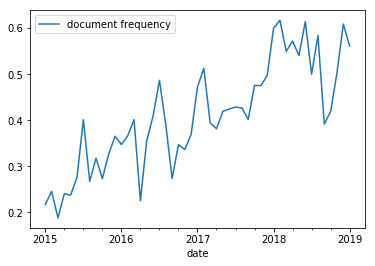

In [16]:
counts=dictionary_document_count(tweets, negative)
plot_time(counts)

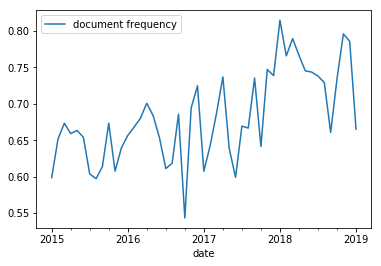

In [17]:
## For personal exploration
counts2=dictionary_document_count(tweets, positive)
plot_time(counts2)

Q3: Create a new dictionary of your own for a concept you'd like to measure in `trump_tweets.json` or `aoc_tweets.json`.  The dictionary must contain at least 10 terms; you're free to create one for any category (except sentiment!), so be creative--we'll be comparing these in class on Thursday. Create a plot using that dictionary and data below.

In [32]:
CHINA_ISSUE_VOCAB = ['china', 'China', 'Beijing', 'ZTE', 'Chinese', 'chinese', 'Xi', 'RMB', 'yuan', 'Yuan'] 

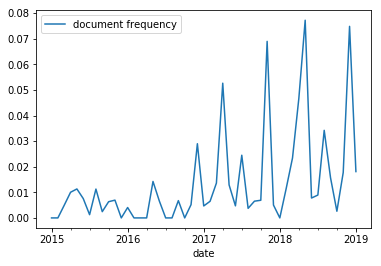

In [19]:
counts3=dictionary_document_count(tweets, CHINA_ISSUE_VOCAB)
plot_time(counts3)

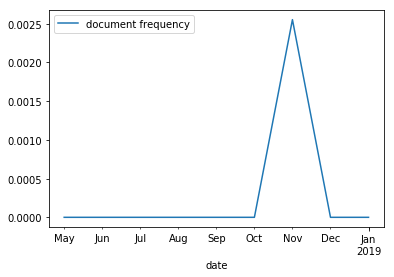

In [31]:
counts4=dictionary_document_count(aoc_tweets, CHINA_ISSUE_VOCAB)
plot_time(counts4)

Q4 (check-plus): for each of the terms in your dictionary, write a function `print_examples(tweets, dictionary)` to find one tweet that contains that term and print it out for your inspection.  Is that term used in the same sense you expected?

In [20]:
from random import shuffle

def print_examples(tweets, dictionary):
    # get random tweets each time
    shuffle(tweets) 
    for tweet in tweets:
        for vocab in dictionary:
            if vocab in tweet[1]:
                print(tweet[0], " ".join(tweet[1]))
                return
    return

In [33]:
print_examples(tweets, CHINA_ISSUE_VOCAB)

2012-08-08 14:51:49 People are finally beginning to hit China and OPEC . They never give me credit for being the first--by far--but that's okay !


In [107]:
## For personal exploration:
def print_all_examples(tweets, dictionary):
    # your code here
    results = []
    for tweet in tweets:
        for vocab in dictionary:
            if vocab in tweet[1]:
                tweet_text = " ".join(tweet[1])
                results.append(tweet_text)
    return results

In [108]:
r = print_all_examples(tweets, CHINA_ISSUE_VOCAB)

In [54]:
len(r)

516